# 0.1.4 Selectable Line Statistics

Rather than sampling randomly between each of the five indices, we should change the implementation so the statistics of each index on each axis can be changed.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn

Wed Mar 27 2019 11:45:42 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.18.0-16-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 821cf34ff14802f195172e5f13c46066474a0376
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Progress bar
from tqdm import tqdm

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [85]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging, as_list, flatten

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## Combigen with a Selectable Number of Lines

As it stands, the number of lines in the resulting `y` is chosen by the `n_lines` argument. Below is what the labels, `y`, look like with the default number of lines ([1,1]) and the resulting inputs, `x`, would look like. 

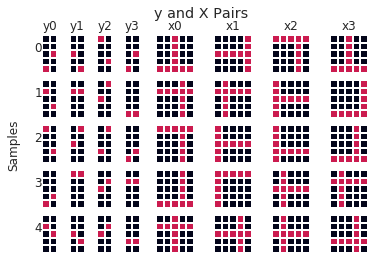

In [11]:
cgh.visualize_combigen(5)
plt.show()

And then this is what it looks like with `n_lines` set to something different.


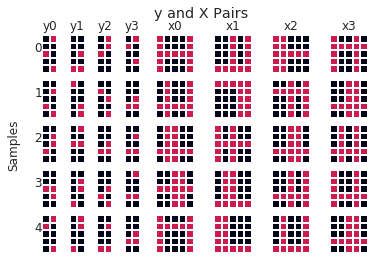

In [12]:
cgh.visualize_combigen(5, n_lines=[1,2])
plt.show()

This way of implementing the lines allows for control over the exact number of lines per axis, but the correct implementation statistically samples all remaining indices of all axes until the correct number of lines is obtained.

Below is the current implmentation of `generate_labels`

In [188]:
def generate_labels(n_samples=1, stack=4, size=5, dims=2, n_lines=None):
    """Returns an array of labels to construct the data from.

    Parameters
    ----------
    n_samples : int, optional
    	Number of samples to return.

    stack : int, optional
    	Number of labels per stack.

    size : int, optional
    	Size of the nxn matrix to use for the task.

    dims : int, optional
    	Number of dimensions for the task.

    n_lines : list or int, optional
    	Number of lines to have on each axis. If an int is provided, then it is
    	used for each axis.
    
    Returns
    -------
    labels : np.ndarray of shape ``(n_samples, stack, size, dims)``
    	The resulting task labels.

    Raises
    ------
    ValueError
    	If ``dims`` does not match the number of lines provided (assuming more
    	than one number was provided for it)
    """
    # Ensure this is a list
    n_lines = as_list(n_lines) if n_lines else [1,1]
    # If one number is passed in for n_lines and there is more than 1 dim, then
    # assume that they should both be set to the value of n_lines.
    if len(n_lines) == 1 and dims != 1:
        n_lines *= dims
    # Ensure dims and `len(n_lines)` is the same
    if dims != len(n_lines):
        raise ValueError('Value for dims must match len(n_lines)')
    
    # Generate a zero array to fill with 1s
    raw_labels = np.zeros((n_samples, stack, size, dims))

    # Create a list of length `dims` that contains arrays with the indices which
    # to set the value to 1. Each array is of shape `n_samples` by `stack` by
    # `n_line[i]` where `i` is the line index.
    arg_ones = [np.array([np.random.choice(range(size), line, replace=False)
                          for _ in range(n_samples*stack)])
                .reshape((n_samples,stack,line))
                for line in n_lines]

    # Use the index arrays created above to set the desired indices of the
    # zero-array to be 1 for each dim in dims.
    for dim, arg_one in enumerate(arg_ones):
        np.put_along_axis(raw_labels[:,:,:,dim], arg_one, values=1, axis=2)
    return raw_labels

## Reworking the Implementation

So now let's rework the implementation so a new argument, `line_stats`, determines the sampling statistics of the possible indices to choose from. `n_lines` will now determine the *total* number of lines, and thus must be an integer.

In [122]:
def generate_labels_statistically(
    n_samples=1, 
    slots=4, 
    size=5, 
    dims=2, 
    n_lines=2, 
    line_stats=None):
    """Returns an array of labels to construct the data from.
    """
    # Ensure `n_lines` is an int
    n_lines = int(n_lines)
    # This will be useful going forward
    n_idx = size * dims
    # It must be less than the number of available indices
    if n_lines >= n_idx:
        raise ValueError('n_lines must be less than size * dims.')
        
    # Normalize `line_stats` to sum to 1 if it isn't already
    if line_stats is not None:
        line_stats = flatten(line_stats)
        if sum(line_stats) != 1.0:
            line_stats = np.array(line_stats) / sum(line_stats)
        
    # Generate a zero array to fill with 1s
    raw_labels = np.zeros((n_samples, slots, n_idx))
    
    # Create a list of length `dims` that contains arrays with the indices which
    # to set the value to 1. Each array is of shape `n_samples` by `stack` by
    # `n_line[i]` where `i` is the line index.
    arg_ones = np.array([np.random.choice(range(n_idx), 
                                          n_lines, 
                                          replace=False,
                                          p=line_stats)
                         for _ in range(n_samples * slots)]).reshape(
        (n_samples, slots, n_lines))

    # Use the index arrays created above to set the desired indices of the
    # zero-array to be 1 for each dim in dims.
    np.put_along_axis(raw_labels, arg_ones, values=1, axis=2)
    return raw_labels.reshape((n_samples, slots, size, dims), order='F')

### Default Configuration

And so lets visualize the changes that were made, starting with the default configuration. Let's try running it until we see a set that has both lines on the same axis.

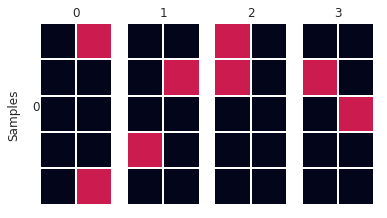

In [103]:
cgh.heatmap(generate_labels_statistically())
plt.show()

### Different Number of Lines

Looks identical to the previous implementation so far but with the extra ability to have lines in the same axis. Now let's try a different number of lines.

3 lines:


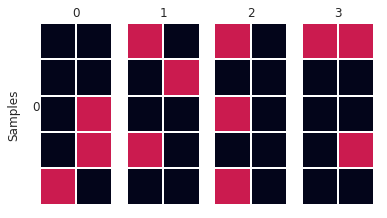

4 lines:


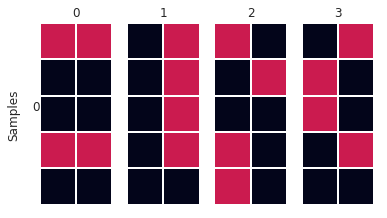

5 lines:


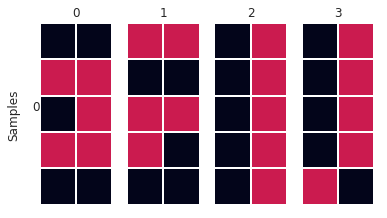

In [106]:
for i in range(3, 6):
    print('{0} lines:'.format(i))
    cgh.heatmap(generate_labels_statistically(n_lines=i))
    plt.show()

### Element Statistics

And finally, let's change the statistics of the different elements. 

#### First and Last Elements

Lets start with being able to select the exact elements we want.

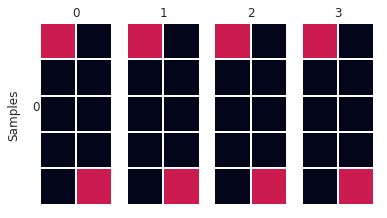

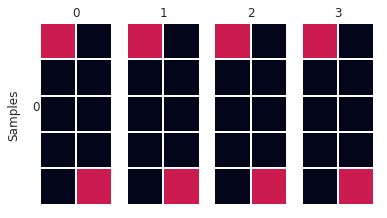

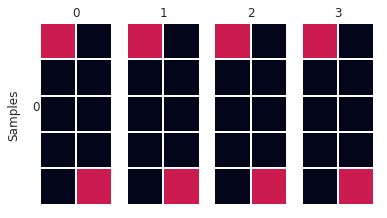

In [124]:
# Only sample first element of the first axis and last element of the second axis
line_stats = [[1,0,0,0,0],[0,0,0,0,1]]
for _ in range(3):
    cgh.heatmap(generate_labels_statistically(line_stats=line_stats))
    plt.show()

#### Line Stats Index Order

Now let's show the ordering of the index. To do this, let's have three alternating elements in the first dimension and two in the second. We should then pass five for `n_lines` so each element is used.

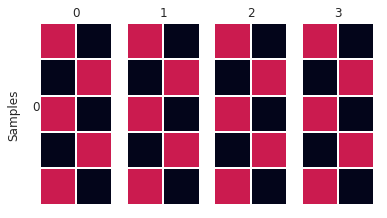

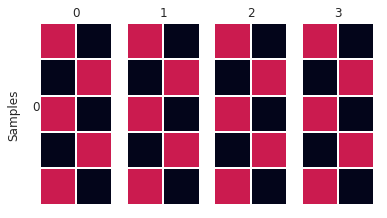

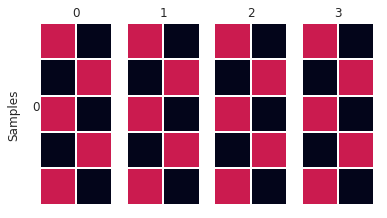

In [127]:
# Two of four positions sampled equally
line_stats = [[1,0,1,0,1], [0,1,0,1,0]]
for _ in range(3):
    cgh.heatmap(generate_labels_statistically(n_lines=5, line_stats=line_stats))
    plt.show()

#### Alternating Elements

In the last couple examples, `n_lines` was set to the same number of possible elements. Let's have two lines alternate between four available slots, but be three times as likely to be in two of them.

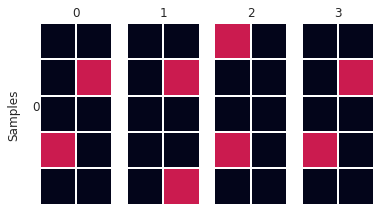

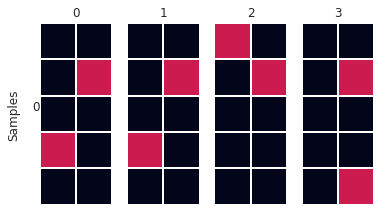

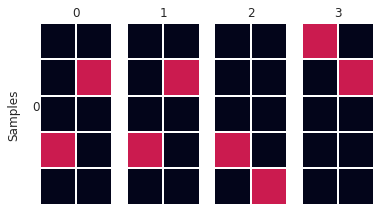

In [133]:
# Only sample first element of the first axis and last element of the second axis
line_stats = [[1,0,0,3,0], [0,3,0,0,1]]
for _ in range(3):
    cgh.heatmap(generate_labels_statistically(n_lines=2,line_stats=line_stats))
    plt.show()

## Ensuring the Statistics are Correct

Let's just quickly try to ensure that the values returned are being set according to the expected statistics.

### Uniform Sampling

A quick way is to create labels with one `n_sample` and `dims`, but `N` numbers of `slots`, which we can then use to compute a sum accross the `slots` axis. What we expect to see is as `N` gets large, the sums all become increasingly similar.

In [170]:
slots = 100

# Create an array containing all the sums of labels with `dims` dimensions. 
y_tests = np.array(
    [generate_labels_statistically(
        n_samples=1, slots=slots, dims=1, n_lines=1).sum(axis=1)
     for _ in range(100)])

# Assert the standard deviation of the means of the sums is less than 1 percent of the total
# number of dimensions used.
assert slots * 0.01 > y_tests.mean(axis=0).std()
print(y_tests.mean(axis=0).std())

0.2630589287593186


As expected they are all quite similar and do not vary much.

### Nonuniform Sampling

Now let's make some slots more likely than others and then take a look at the means of the sums.

In [167]:
line_stats = np.array([1,2,3,4,5])

# Create an array containing all the sums of labels with `dims` dimensions. 
y_tests = np.array(
    [generate_labels_statistically(
        n_samples=1, 
        slots=slots, 
        dims=1, 
        n_lines=1, 
        line_stats=line_stats,
    ).sum(axis=1)
     for _ in range(100)])

# Separate out the means of sums
means = y_tests.mean(axis=0).reshape((5))

# Assert the different pair-wise sums are as expected of the stats defined above.
for l, m in zip(line_stats, means):
    assert np.isclose(means[0]*l, m, atol=slots*0.05/size)
print(means)

[ 67.06 134.06 199.71 265.22 333.95]


Now let's run a couple tests on this.